In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import *
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp 
from fbprophet import Prophet
import time

In [3]:
def general_trend (datapath):
    # read original data
    df_temp=pd.read_csv(datapath)
    #delete the last row since the only one data on Nov makes confusion
    df=df_temp.drop(df_temp.index[len(df_temp)-1])
    num_total=len(df)
    
    # date form transmission (e.g. 2016/09/15 ---> 2016-09-15)
    for i in range(num_total):
        w=df["post_date"][i].split('/')
        q='-'.join(w)
        df.loc[i,"post_date"]= q
    
    # for the puepose on extracting data based on y/m
    ym=['2016-09','2016-10','2016-11','2016-12','2017-01','2017-02','2017-03','2017-04','2017-05','2017-06','2017-07','2017-08','2017-09',\
   '2017-10','2017-11','2017-12','2018-01','2018-02','2018-03','2018-04','2018-05','2018-06','2018-07','2018-08',\
   '2018-09','2018-10']
    df['ym']=0
    for i in range(num_total):
        df.loc[i,"ym"]= df["post_date"][i][0:7]
    
    df_time=[]
    df_time_pos=[]
    df_time_neg=[]
    num_reviews=[]
    num_reviews_pos=[]
    num_reviews_neg=[]
    for a in ym:
        # store the dataframe every month into a list. df_time[0] means the dataframe on 15/09/2016
        df_time.append(df[df["ym"]==a])
        df_time_pos.append(df[(df["ym"]==a) & (df["recommend_or_not"]=="Recommended")])
        df_time_neg.append(df[(df["ym"]==a) & (df["recommend_or_not"]=="Not Recommended")])
    time_interval=len(df_time)
    for i in range(time_interval):
        num_reviews.append(len(df_time[i]))
        num_reviews_pos.append(len(df_time_pos[i]))
        num_reviews_neg.append(len(df_time_neg[i]))
        
    # positive / total
    num_pro=[]
    for i in range(len(num_reviews)):
        if num_reviews[i]==0:
            num_pro.append(0)
        else:
            num_pro.append(num_reviews_pos[i]/num_reviews[i]*100)
            
    # plot
    plt.subplot(211) 
    s1=plt.bar(ym, num_reviews, label='Negative')
    s2=plt.bar(ym, num_reviews_pos, label='Positive')
    plt.title("Review Analysis per Month")
    plt.ylabel('number of reviews')
    plt.xlabel('data')
    plt.legend()

    plt.subplot(212) 
    s3=plt.bar(ym, num_pro, label='positive feedback')
    plt.title("postive rating")
    plt.ylabel('posivie/total %')
    plt.xlabel('data')
    plt.legend()

    print("Average of positive rating: \n")
    ave_num = sum(num_pro)/len(num_pro)
    print(ave_num)

In [5]:
def trend_prediction_sketch(datapath):
    # read original data
    df_temp=pd.read_csv(datapath)
    #delete the last row since the only one data on Nov makes confusion
    df=df_temp.drop(df_temp.index[len(df_temp)-1])
    num_total=len(df)
    
    # date form transmission (e.g. 2016/09/15 ---> 2016-09-15)
    for i in range(num_total):
        w=df["post_date"][i].split('/')
        q='-'.join(w)
        df.loc[i,"post_date"]= q
    
    # Data analysis per day (2016-09-15 ~ 2018-8-31)
    # create a dictionary to store number of reviews every day
    dic ={}
    for i in range(num_total):
        date = df.iloc[i]["post_date"]
        if date not in dic:
            dic[date] =1
        else:
            dic[date]+=1
            
    # construct data collection based on fbprophet's requirment
    ds=[]
    y=[]
    for name in dic.keys():
        ds.append(name)
    for num in dic.values():
        y.append(num)
        
    df_daily_all = pd.DataFrame() 
    df_daily_all["ds"] = ds
    df_daily_all["y"] = y
    df_daily = df_daily_all.drop(df_daily_all.index[620:]) # known
    df_daily_actual = df_daily_all.drop(df_daily_all.index[:620]) # need prediction
    df_daily_official = df_daily_all.iloc[284:620] # after release date, before Oct 2018
    df_daily_official_all = df_daily_all.iloc[284:] # after release date
    
    # third degree polynomial
    y_temp=[]
    x = np.arange(0,len(df_daily_official),1)
    for i in range(len(df_daily_official)):
        y_temp.append(df_daily_official["y"][i+284])
    y = np.array(y_temp)
    z1 = np.polyfit(x, y, 3)
    p1 = np.poly1d(z1)
    print(p1) # print polynomial formula
    yvals = p1(x)  # fit y

    plot1 = plt.plot(x, y, 's',label='original values')
    plot2 = plt.plot(x, yvals, 'r',label='polyfit values')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc=1) 
    plt.title('third dgree polyfitting')
    plt.show()
    
    dist_poly = []
    x_poly = np.arange(0,len(df_daily_official_all),1)
    y_poly = [(-1.054e-05 *x*x*x - 0.006519 *x*x + 1.23 *x +73.64) for x in x_poly] 
    for i in range(len(df_daily_official_all)):
        temp=abs(y_poly[i]-df_daily_all["y"][i])
        dist_poly.append(temp)
    score_poly = sum(dist_poly)/len(df_daily_all)
    print("similarity score is :")
    print(score_poly)
    print("\n")
    
    # exponential curve fitting
    x = np.arange(1,len(df_daily_official)+1,1)
    y = np.array(y_temp)
    def func(x,a,b):
        return a*np.exp(b/x)
    popt, pcov = curve_fit(func, x, y)
    a=popt[0]
    b=popt[1]
    yvals=func(x,a,b)
    print (u'parameter a:', a)
    print (u'parameter b:', b)
    plot1=plt.plot(x, y, '*',label='original values')
    plot2=plt.plot(x, yvals, 'r',label='curve_fit values')
    plt.xlabel('x axis')
    plt.ylabel('y axis')
    plt.legend(loc=1)
    plt.title('curve_fit')
    
    dist_exp = []
    x_exp = np.arange(1,len(df_daily_official_all)+1,1)
    y_exp = [12.30452657404054*np.exp(2.869100023130686/x) for x in x_exp] 
    for i in range(len(df_daily_official_all)):
        temp=abs(y_exp[i]-df_daily_all["y"][i])
        dist_exp.append(temp)
    score_exp = sum(dist_exp)/len(df_daily_all)
    print("similarity score is :")
    print(score_exp)

In [9]:
def trend_prediction_tsf(datapath):
    # read original data
    df_temp=pd.read_csv(datapath)
    #delete the last row since the only one data on Nov makes confusion
    df=df_temp.drop(df_temp.index[len(df_temp)-1])
    num_total=len(df)
    
    # date form transmission (e.g. 2016/09/15 ---> 2016-09-15)
    for i in range(num_total):
        w=df["post_date"][i].split('/')
        q='-'.join(w)
        df.loc[i,"post_date"]= q
    
    # Data analysis per day (2016-09-15 ~ 2018-8-31)
    # create a dictionary to store number of reviews every day
    dic ={}
    for i in range(num_total):
        date = df.iloc[i]["post_date"]
        if date not in dic:
            dic[date] =1
        else:
            dic[date]+=1
            
    # construct data collection based on fbprophet's requirment
    ds=[]
    y=[]
    for name in dic.keys():
        ds.append(name)
    for num in dic.values():
        y.append(num)
        
    df_daily_all = pd.DataFrame() 
    df_daily_all["ds"] = ds
    df_daily_all["y"] = y
    df_daily = df_daily_all.drop(df_daily_all.index[620:]) # known
    df_daily_actual = df_daily_all.drop(df_daily_all.index[:620]) # need prediction
    df_daily_official = df_daily_all.iloc[284:620] # after release date, before Oct 2018
    df_daily_official_all = df_daily_all.iloc[284:] # after release date
    
    # model fitting and prediction
    model = Prophet()
    model.fit(df_daily)
    future = model.make_future_dataframe(periods=61, freq = 'd')
    print("The time-series forecasting with all sample data: \n")
    forecast = model.predict(future)
    model.plot(forecast);
    
    # model fitting and prediction (selected sample)
    model2 = Prophet()
    model2.fit(df_daily_official)
    future2 = model2.make_future_dataframe(periods=61, freq = 'd')
    forecast2 = model2.predict(future2)
    forecast2.head()
    print("The time-series forecasting with selected sample data (for better fitting ratio): \n")
    model2.plot(forecast2);
    
    # combine actual values with predicted values
    df_daily_official_all.set_index('ds', inplace=True)
    forecast2.set_index('ds', inplace=True)
    viz_df2 = df_daily_official_all.join(forecast2[['yhat', 'yhat_lower','yhat_upper']], how = 'outer').fillna(0)
    
    # calculate the similar score(Time-Series Forecasting)
    def dist(dataframe):
        dist=[]
        length=len(dataframe)
        for i in range(length):
            temp=abs((abs(dataframe['yhat'][i])-abs(dataframe['y'][i])))
            dist.append(temp)
        return dist

    distance = dist(viz_df2)
    score = sum(distance)/len(viz_df2)
    
    print("Visualization : ")
    viz_df2[['y', 'yhat']].plot()
    
    print("similarity score is : \n")
    print(score)
    
    

General Trend:
Average of positive rating: 

81.69031102811851
Polynomial fitting and Exponential curve fitting:
            3            2
-1.054e-05 x + 0.006519 x - 1.23 x + 73.64


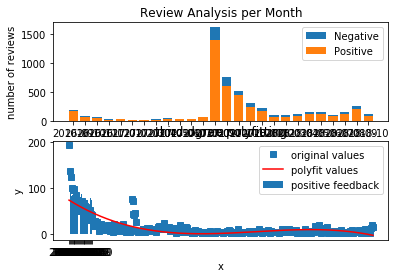

similarity score is :
163.62900364951395


parameter a: 12.30452657404054
parameter b: 2.869100023130686
similarity score is :
7.792709825757792
Time-series Forecasting:


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
K:\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


The time-series forecasting with all sample data: 



INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The model details: 

The time-series forecasting with selected sample data (for better fitting ratio): 

Visualization : 
similarity score is : 

4.87978148756082


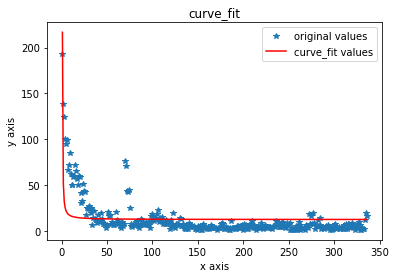

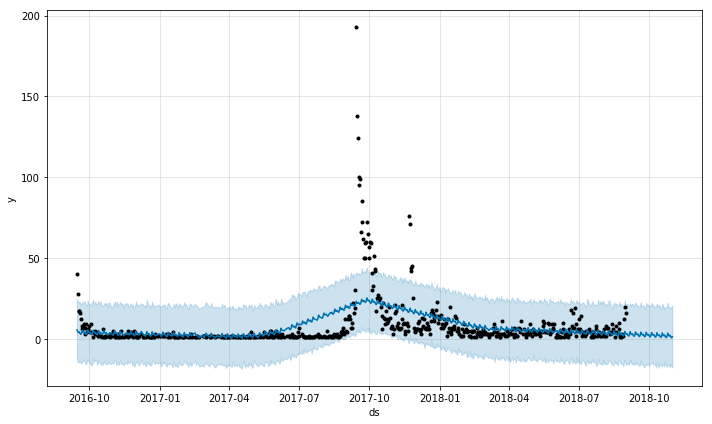

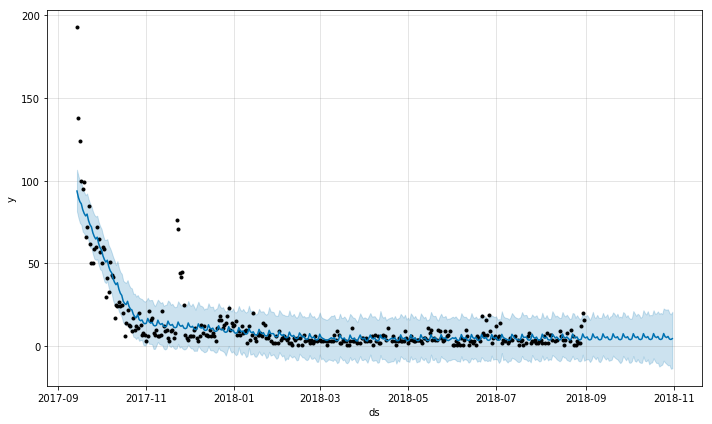

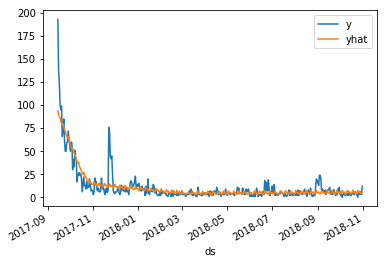

In [11]:
if __name__ == "__main__":
    datapath="BIA-660 Project Data Subset.csv"
    print("General Trend:")
    general_trend(datapath)
    print("Polynomial fitting and Exponential curve fitting:")
    trend_prediction_sketch(datapath)
    print("Time-series Forecasting:")
    trend_prediction_tsf(datapath)